In [2]:
import os

import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from resnet_9_model import *

In [3]:
resize_shape = (48,48)
# resize_shape = (32,32)
# resize_shape = (64,64)

data_dir = '/home/selimon/Desktop/AI/wdwyl_ros1/src/perception/brand_classification/data/training_validation'
print(os.listdir(data_dir))

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))


train_tfms = tt.Compose([
    tt.Resize(resize_shape),
    tt.RandomHorizontalFlip(), 
    tt.RandomRotation(10),
    tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    tt.ToTensor(), 
    tt.Normalize(*stats, inplace=True)
])

valid_tfms = tt.Compose([
    tt.Resize(resize_shape),
    tt.ToTensor(), 
    tt.Normalize(*stats)
])

# Load dataset
full_dataset = ImageFolder(data_dir)

# Define lengths for train and valid datasets
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size

# Split dataset into train and valid sets
train_ds, valid_ds = random_split(full_dataset, [train_size, valid_size])

# Apply transformations to train and valid sets
train_ds.dataset.transform = train_tfms
valid_ds.dataset.transform = valid_tfms

['4_pines', 'crown', 'great_northern', 'heineken']


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


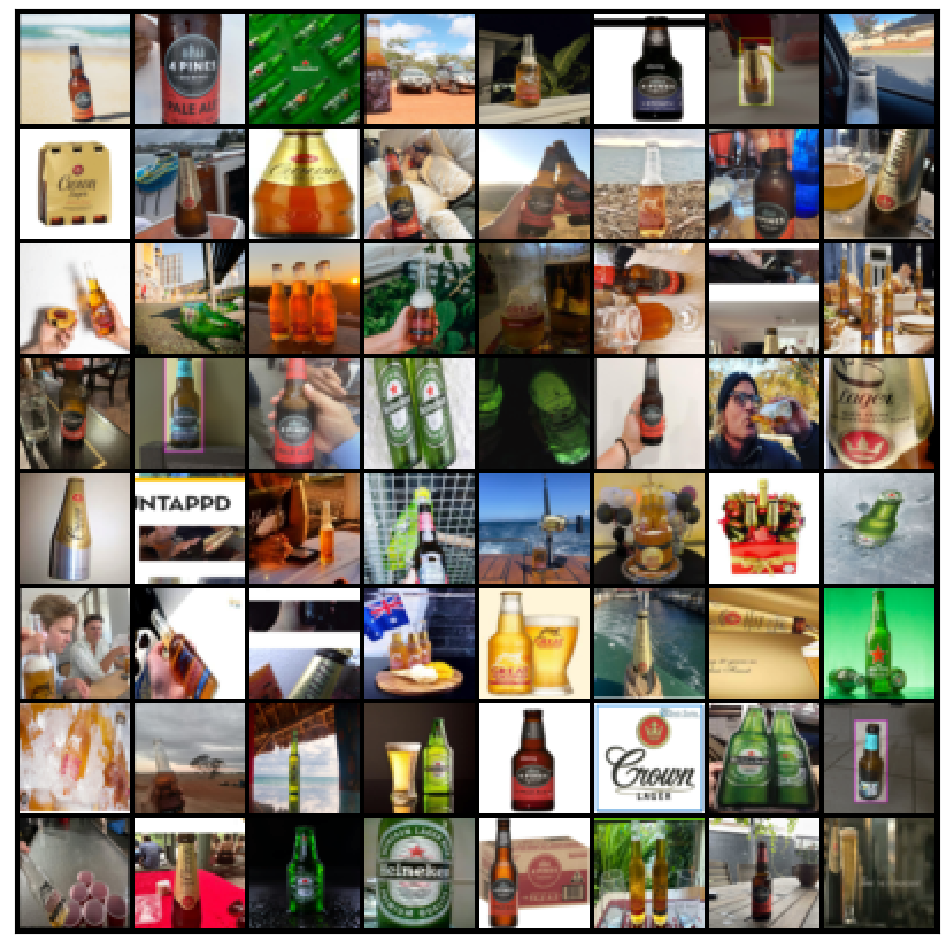

In [4]:
batch_size = 80

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=3, pin_memory=True)

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
    
show_batch(train_dl)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
    
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

cuda


## Defining Model

In [6]:
model = to_device(ResNet9(3, 5), device)
print(model)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training Model

In [7]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [8]:
history = [evaluate(model, valid_dl)]
print(history)

epochs = 50
max_lr = 0.0125
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

[{'val_loss': 1.6029162406921387, 'val_acc': 0.34375}]


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [0], last_lr: 0.00060, train_loss: 1.4300, val_loss: 1.5378, val_acc: 0.3250


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1], last_lr: 0.00096, train_loss: 1.2786, val_loss: 1.3343, val_acc: 0.5500


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2], last_lr: 0.00157, train_loss: 1.1998, val_loss: 1.3636, val_acc: 0.5312


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3], last_lr: 0.00240, train_loss: 1.1788, val_loss: 1.4759, val_acc: 0.4187


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4], last_lr: 0.00341, train_loss: 1.1635, val_loss: 1.4009, val_acc: 0.4937


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5], last_lr: 0.00456, train_loss: 1.1413, val_loss: 1.4531, val_acc: 0.4500


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6], last_lr: 0.00579, train_loss: 1.1182, val_loss: 1.2568, val_acc: 0.6313


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7], last_lr: 0.00705, train_loss: 1.1197, val_loss: 1.3445, val_acc: 0.5625


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8], last_lr: 0.00829, train_loss: 1.1436, val_loss: 1.3498, val_acc: 0.5500


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9], last_lr: 0.00945, train_loss: 1.1514, val_loss: 1.3734, val_acc: 0.5250


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10], last_lr: 0.01048, train_loss: 1.1591, val_loss: 1.2702, val_acc: 0.6187


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [11], last_lr: 0.01134, train_loss: 1.1936, val_loss: 1.5160, val_acc: 0.3875


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [12], last_lr: 0.01197, train_loss: 1.1769, val_loss: 1.3863, val_acc: 0.5187


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [13], last_lr: 0.01237, train_loss: 1.1579, val_loss: 1.4172, val_acc: 0.4812


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [14], last_lr: 0.01250, train_loss: 1.2193, val_loss: 1.2702, val_acc: 0.6313


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [15], last_lr: 0.01247, train_loss: 1.1754, val_loss: 1.4686, val_acc: 0.4313


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [16], last_lr: 0.01240, train_loss: 1.1855, val_loss: 1.3665, val_acc: 0.5312


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [17], last_lr: 0.01227, train_loss: 1.1363, val_loss: 1.4101, val_acc: 0.4875


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [18], last_lr: 0.01210, train_loss: 1.1994, val_loss: 1.3193, val_acc: 0.5813


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [19], last_lr: 0.01188, train_loss: 1.1688, val_loss: 1.2467, val_acc: 0.6500


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [20], last_lr: 0.01162, train_loss: 1.1092, val_loss: 1.2528, val_acc: 0.6562


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [21], last_lr: 0.01131, train_loss: 1.1935, val_loss: 1.3939, val_acc: 0.5000


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [22], last_lr: 0.01096, train_loss: 1.1317, val_loss: 1.3116, val_acc: 0.5875


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [23], last_lr: 0.01057, train_loss: 1.1180, val_loss: 1.2605, val_acc: 0.6375


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [24], last_lr: 0.01015, train_loss: 1.0982, val_loss: 1.2742, val_acc: 0.6313


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [25], last_lr: 0.00969, train_loss: 1.0894, val_loss: 1.2334, val_acc: 0.6688


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [26], last_lr: 0.00921, train_loss: 1.0623, val_loss: 1.3034, val_acc: 0.6000


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [27], last_lr: 0.00871, train_loss: 1.1002, val_loss: 1.2266, val_acc: 0.6688


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [28], last_lr: 0.00818, train_loss: 1.0912, val_loss: 1.1710, val_acc: 0.7312


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [29], last_lr: 0.00764, train_loss: 1.0756, val_loss: 1.1828, val_acc: 0.7250


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [30], last_lr: 0.00709, train_loss: 1.0577, val_loss: 1.1562, val_acc: 0.7625


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [31], last_lr: 0.00653, train_loss: 1.0553, val_loss: 1.2087, val_acc: 0.6875


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [32], last_lr: 0.00597, train_loss: 1.0392, val_loss: 1.2050, val_acc: 0.7000


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [33], last_lr: 0.00541, train_loss: 1.0288, val_loss: 1.1924, val_acc: 0.7125


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [34], last_lr: 0.00486, train_loss: 1.0263, val_loss: 1.1946, val_acc: 0.7063


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [35], last_lr: 0.00432, train_loss: 1.0038, val_loss: 1.2022, val_acc: 0.7000


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [36], last_lr: 0.00379, train_loss: 0.9912, val_loss: 1.1463, val_acc: 0.7563


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [37], last_lr: 0.00329, train_loss: 0.9885, val_loss: 1.1573, val_acc: 0.7437


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [38], last_lr: 0.00281, train_loss: 0.9866, val_loss: 1.1515, val_acc: 0.7437


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [39], last_lr: 0.00235, train_loss: 0.9750, val_loss: 1.1586, val_acc: 0.7313


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [40], last_lr: 0.00193, train_loss: 0.9697, val_loss: 1.1597, val_acc: 0.7312


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [41], last_lr: 0.00154, train_loss: 0.9626, val_loss: 1.1274, val_acc: 0.7812


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [42], last_lr: 0.00119, train_loss: 0.9761, val_loss: 1.1193, val_acc: 0.7875


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [43], last_lr: 0.00088, train_loss: 0.9674, val_loss: 1.1137, val_acc: 0.7875


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [44], last_lr: 0.00062, train_loss: 0.9605, val_loss: 1.1057, val_acc: 0.8000


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [45], last_lr: 0.00040, train_loss: 0.9604, val_loss: 1.0988, val_acc: 0.8062


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [46], last_lr: 0.00023, train_loss: 0.9594, val_loss: 1.0955, val_acc: 0.8062


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [47], last_lr: 0.00010, train_loss: 0.9563, val_loss: 1.0959, val_acc: 0.8062


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [48], last_lr: 0.00003, train_loss: 0.9521, val_loss: 1.0970, val_acc: 0.8062


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [49], last_lr: 0.00000, train_loss: 0.9588, val_loss: 1.0984, val_acc: 0.8062


## Plotting

#### Plotting Accuracy

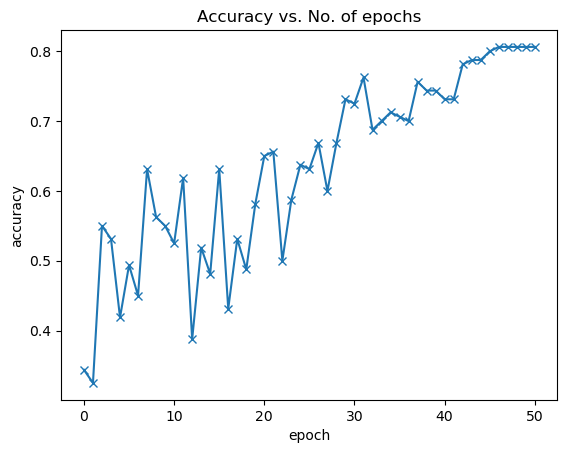

In [9]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
    
plot_accuracies(history)

#### Plotting Losses

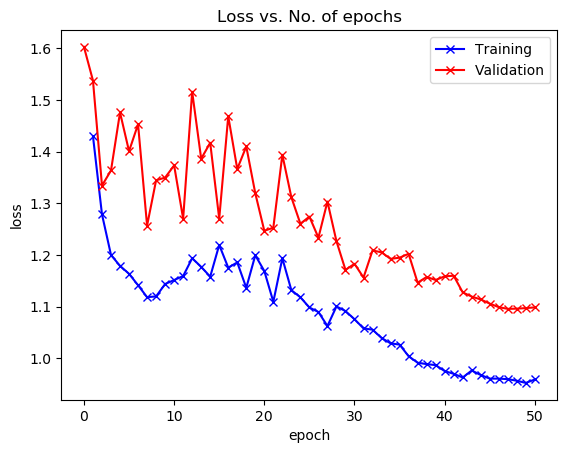

In [10]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
plot_losses(history)

Plottings Learning Rate Change Over Time

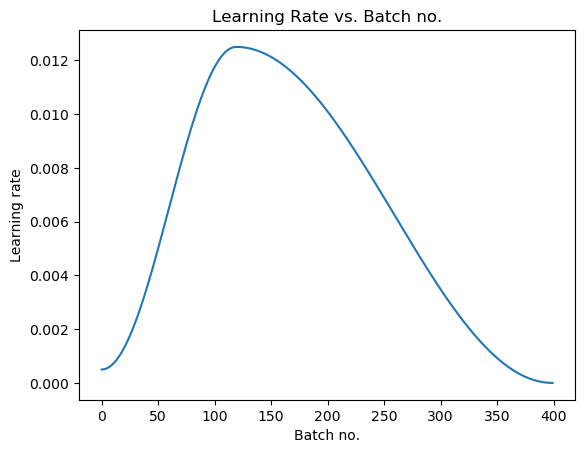

In [11]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    
plot_lrs(history)

# Saving Model

In [12]:
torch.save(model.state_dict(), 'resnet9_model.pth')

In [13]:
len(train_ds)

639